In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
from utils import *


In [3]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
        self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.threshold = torch.zeros(n_units)

        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []
    
    def update(self, x, eps=0.5, dt=0.002):

        

        # iterate over batch
        for i in range(batch_size):
                
            x_vec = x[:,i] 
            
            # forward pass
            y_vec = torch.matmul(self.weights, x_vec) 

            # update threshold
            self.threshold = torch.mean(y_vec)**2
            t  = self.threshold.reshape(-1, 1)
            
            # calc weight update
            phi = y_vec * (y_vec - t) 
            
            phi = phi[0]
            print("ph", phi)
            delta_w = torch.outer(phi, x_vec)   - eps * self.weights

            # update weights
            self.weights += delta_w * dt





        

        # tracking
      #  self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
      #  self.activations.append(torch.mean(y, dim=1)) # append mean over batch

In [4]:
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# # for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps#
n_epochs = 1
n_units = 10
batch_size = 100

model = BCM_Model(n_in, n_units)
#model = BCM_Model_Squadrani(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
    draw_weights(model.weights, epoch)



torch.Size([400, 784])
ph tensor([0.5961, 0.0405, 1.1915, 4.9839, 0.9050, 1.0642, 0.0156, 1.6056, 0.2336,
        0.4563], dtype=torch.float64)
ph tensor([2.2590, 0.4352, 0.2112, 0.0613, 0.1898, 1.4827, 1.6155, 0.1349, 0.7735,
        1.4939], dtype=torch.float64)
ph tensor([3.8231e+00, 7.7962e-01, 1.8402e+00, 1.9868e-04, 2.6742e-02, 3.2151e-01,
        2.8395e+00, 7.5819e-01, 4.7729e-01, 3.3696e-01], dtype=torch.float64)
ph tensor([3.2183e+00, 3.9315e+00, 1.9269e-01, 6.4087e+00, 2.8584e-01, 4.4510e-02,
        4.7512e-01, 8.6643e-04, 7.4131e-01, 3.5876e-02], dtype=torch.float64)
ph tensor([-0.6124,  0.5472,  0.0577, 24.8032,  0.0981,  0.1177,  0.0821,  2.4754,
        -0.7437, -0.6485], dtype=torch.float64)
ph tensor([-7.9803e+00, -1.7306e+00, -1.4054e-01,  3.5461e+02, -1.7576e+01,
        -3.0020e-01, -2.0410e-01, -3.0818e+01, -2.2657e+00, -7.1851e+00],
       dtype=torch.float64)
ph tensor([ 3.6686e+03,  7.9636e+02,  6.4670e+01, -1.0917e+05,  8.0254e+03,
         1.3814e+02,  9.3917

ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 1290x200 with 2 Axes>

In [ ]:
model.weights

tensor([[ 8.8073e-02, -9.6301e-02,  2.5855e-02,  ...,  1.6930e-02,
         -8.6950e-03, -9.1607e-02],
        [ 5.3031e-05,  6.0482e-02,  1.3237e-02,  ...,  1.0227e-01,
          4.3796e-02, -1.3204e-02],
        [ 9.2481e-02, -7.2153e-02, -1.3128e-02,  ..., -6.3017e-02,
         -4.9339e-02, -1.3695e-02],
        ...,
        [-1.8709e-02,  4.6072e-02,  2.9781e-02,  ...,  3.8554e-02,
          3.1166e-03,  1.5911e-02],
        [ 1.9951e-02, -1.8842e-02,  1.9266e-02,  ...,  2.3583e-02,
          3.5863e-02,  1.5229e-02],
        [ 4.0534e-02, -5.5152e-02,  8.1093e-02,  ..., -1.1332e-02,
          7.3148e-03,  8.7953e-03]], dtype=torch.float64)

### Visual Analysis

#### Selectivity

In [ ]:
img = np.array(model.selectivity)
img =img.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

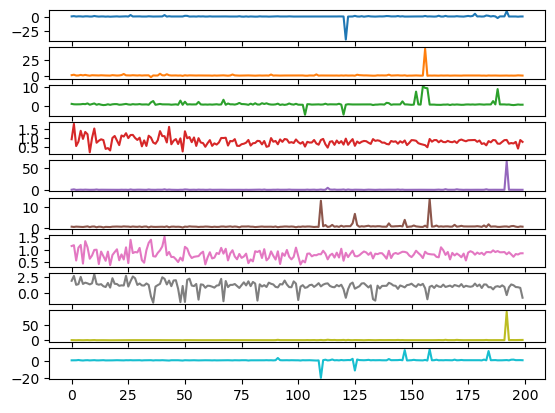

In [ ]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i,:] for i in range(n_units)})
df.plot(subplots=True, legend=False)

#### Threshold

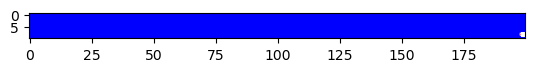

In [ ]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [ ]:
t.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

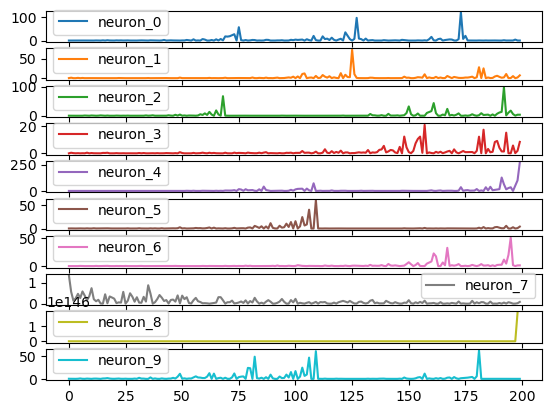

In [ ]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': t[i, :] for i in range(n_units)})
df.plot(subplots=True)

#### Activations

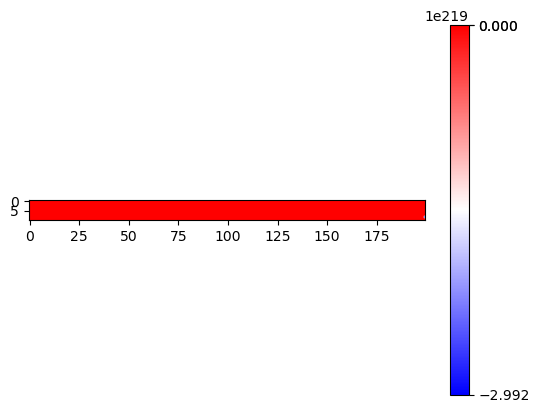

In [ ]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [ ]:
y.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

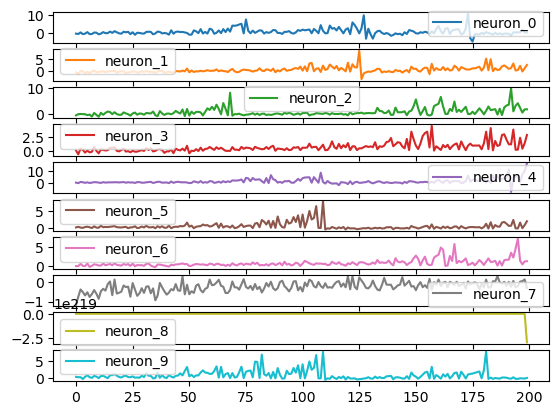

In [ ]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': y[i, :] for i in range(n_units)})
df.plot(subplots=True)

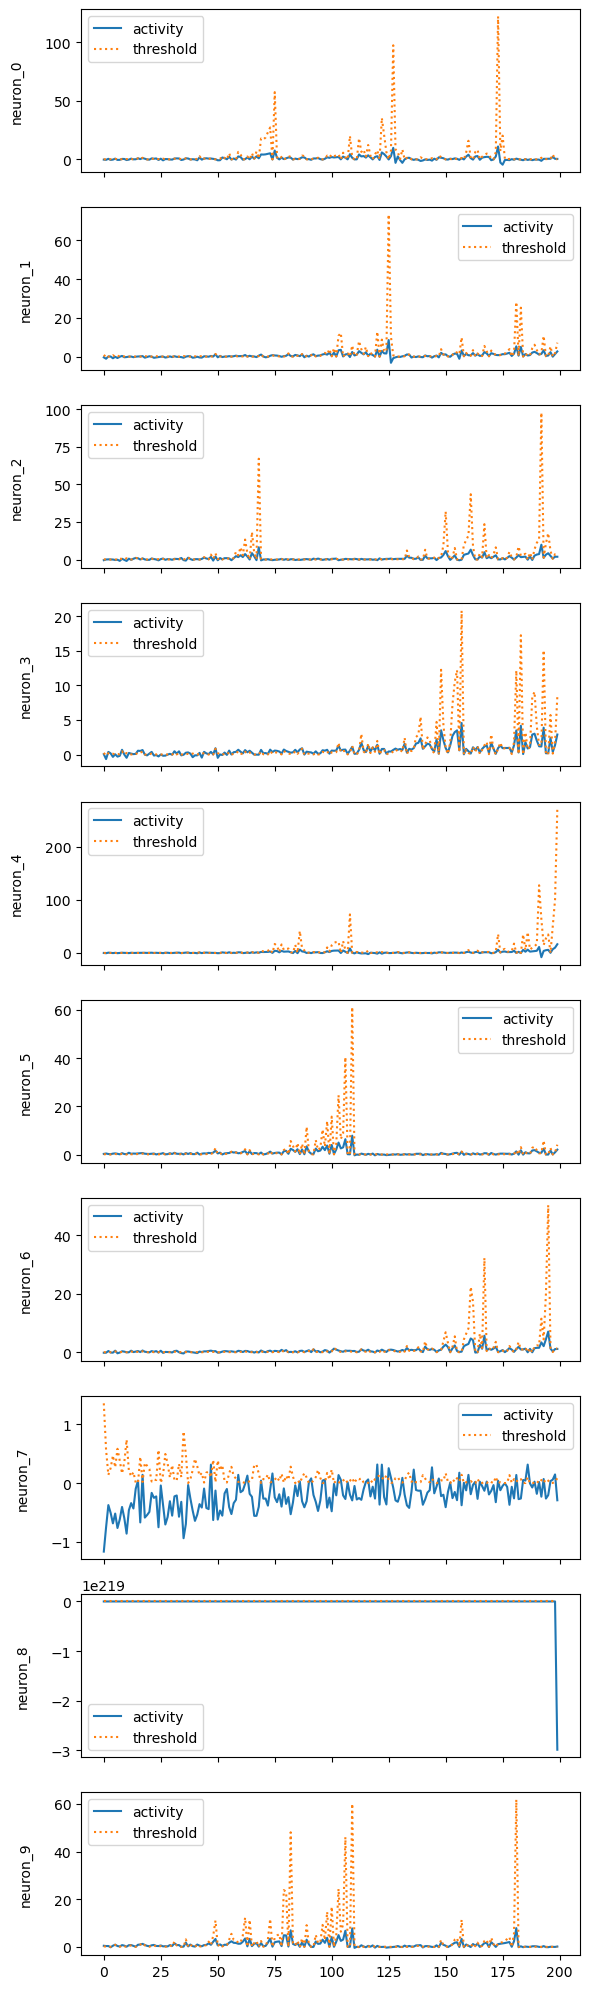

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

In [ ]:
import seaborn as sns

In [ ]:
y.shape

(10, 200)

In [ ]:
y[i,:]

array([ 4.66643575e-01,  3.58852704e-01,  3.69651640e-01, -1.54521721e-01,
        4.90720767e-01,  9.33203401e-01,  3.62539357e-01,  1.78176522e-01,
        7.50035439e-01,  5.18106940e-01,  1.05196894e-01,  7.17529941e-01,
        7.65571120e-01,  4.21648507e-01,  7.45342746e-02,  8.99391370e-01,
        9.73674025e-01,  1.26842530e+00,  8.05272272e-01,  4.29450714e-01,
        2.81881878e-01,  6.72957952e-01,  8.25913299e-01,  4.05107364e-01,
        3.49341329e-01,  6.00096473e-01,  2.29270039e-01,  2.87680670e-01,
        2.04244993e-01,  7.69437106e-01,  4.05799982e-01,  1.50372226e+00,
        7.85599501e-01,  7.51314243e-01,  1.73255850e-02,  1.17281580e-01,
        1.77857222e+00,  1.94284802e-01,  9.70284875e-01,  3.12776912e-01,
        1.16921339e-01,  9.88701360e-01,  5.41925012e-01,  2.61561975e-01,
        7.62016401e-01,  8.40528704e-01,  1.48460335e+00,  8.77903316e-01,
        2.15644312e+00,  3.32201717e+00,  6.31591856e-01,  1.05020690e+00,
        4.00242594e-01,  

In [ ]:
t[i,:]

array([2.17756226e-01, 1.28775264e-01, 1.36642335e-01, 2.38769624e-02,
       2.40806871e-01, 8.70868588e-01, 1.31434786e-01, 3.17468731e-02,
       5.62553160e-01, 2.68434801e-01, 1.10663865e-02, 5.14849217e-01,
       5.86099139e-01, 1.77787463e-01, 5.55535809e-03, 8.08904837e-01,
       9.48041106e-01, 1.60890275e+00, 6.48463433e-01, 1.84427916e-01,
       7.94573934e-02, 4.52872405e-01, 6.82132777e-01, 1.64111977e-01,
       1.22039364e-01, 3.60115777e-01, 5.25647506e-02, 8.27601676e-02,
       4.17160170e-02, 5.92033460e-01, 1.64673625e-01, 2.26118064e+00,
       6.17166575e-01, 5.64473092e-01, 3.00175895e-04, 1.37549691e-02,
       3.16331913e+00, 3.77465844e-02, 9.41452739e-01, 9.78293967e-02,
       1.36705995e-02, 9.77530380e-01, 2.93682719e-01, 6.84146668e-02,
       5.80668996e-01, 7.06488502e-01, 2.20404710e+00, 7.70714233e-01,
       4.65024694e+00, 1.10357981e+01, 3.98908272e-01, 1.10293452e+00,
       1.60194134e-01, 8.28296445e-01, 7.56835869e-01, 3.01809662e+00,
      

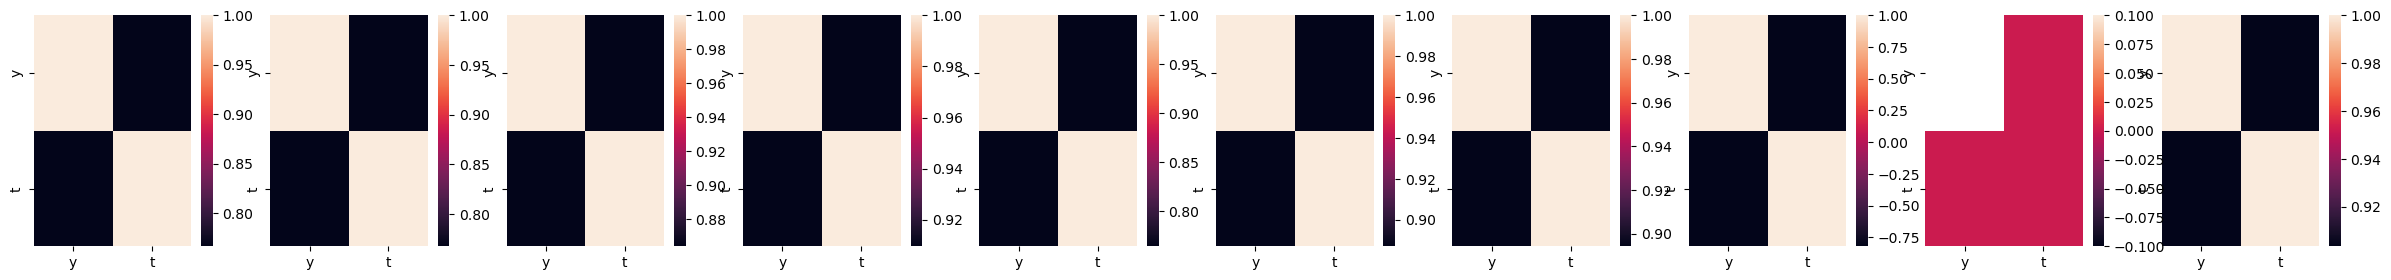

In [ ]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])